<div class="alert alert-block alert-success">
    <b><center>CNN Basic Examples</center></b>
    <b><center>Basic CNN</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install git+https://github.com/nockchun/rspy --force
# !pip install mybatis_mapper2sql
import rspy as rsp
rsp.setSystemWarning(off=True)

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, datasets, utils

In [3]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
np.set_printoptions(linewidth=200, precision=2)
tf.__version__

'2.2.0'

# Use the same graph of layers to define multiple models
In the functional API, models are created by specifying their inputs and outputs in a graph of layers. That means that a single graph of layers can be used to generate multiple models.

In the example below, you use the same stack of layers to instantiate two models: an encoder model that turns image inputs into 16-dimensional vectors, and an end-to-end autoencoder model for training.

In [5]:
encoder_input = layers.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

In [7]:
encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [10]:
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

In [11]:
autoencoder = models.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

Here, the decoding architecture is strictly symmetrical to the encoding architecture, so the output shape is the same as the input shape (28, 28, 1).

The reverse of a Conv2D layer is a Conv2DTranspose layer, and the reverse of a MaxPooling2D layer is an UpSampling2D layer.

# All models are callable, just like layers
You can treat any model as if it were a layer by invoking it on an Input or on the output of another layer. By calling a model you aren't just reusing the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that creates an encoder model, a decoder model, and chains them in two calls to obtain the autoencoder model:

In [13]:
encoder_input = layers.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

In [15]:
encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

In [16]:
decoder_input = layers.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

In [18]:
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         145 

In [21]:
autoencoder_input = layers.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


As you can see, the model can be nested: a model can contain sub-models (since a model is just like a layer). A common use case for model nesting is ensembling. For example, here's how to ensemble a set of models into a single model that averages their predictions:

In [23]:
def get_model():
    inputs = layers.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return models.Model(inputs, outputs)

In [24]:
model1 = get_model()
model2 = get_model()
model3 = get_model()

In [26]:
inputs = layers.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = models.Model(inputs=inputs, outputs=outputs)

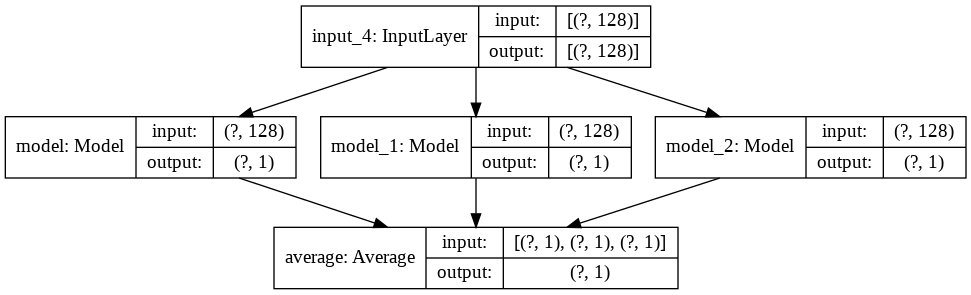

In [27]:
utils.plot_model(ensemble_model, "intermediate/model.png", True)

# Manipulate complex graph topologies

Models with multiple inputs and outputs
The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the Sequential API.

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

* the title of the ticket (text input),
* the text body of the ticket (text input), and
* any tags added by the user (categorical input)

This model will have two outputs:
* the priority score between 0 and 1 (scalar sigmoid output), and
* the department that should handle the ticket (softmax output over the set of departments).

You can build this model in a few lines with the functional API:

In [28]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

In [30]:
title_input = layers.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = layers.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = layers.Input(shape=(num_tags,), name="tags")  # Binary vectors of size `num_tags`

In [31]:
# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

In [32]:
# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

In [33]:
# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

In [34]:
# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

In [36]:
# Instantiate an end-to-end model predicting both priority and department
model = models.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

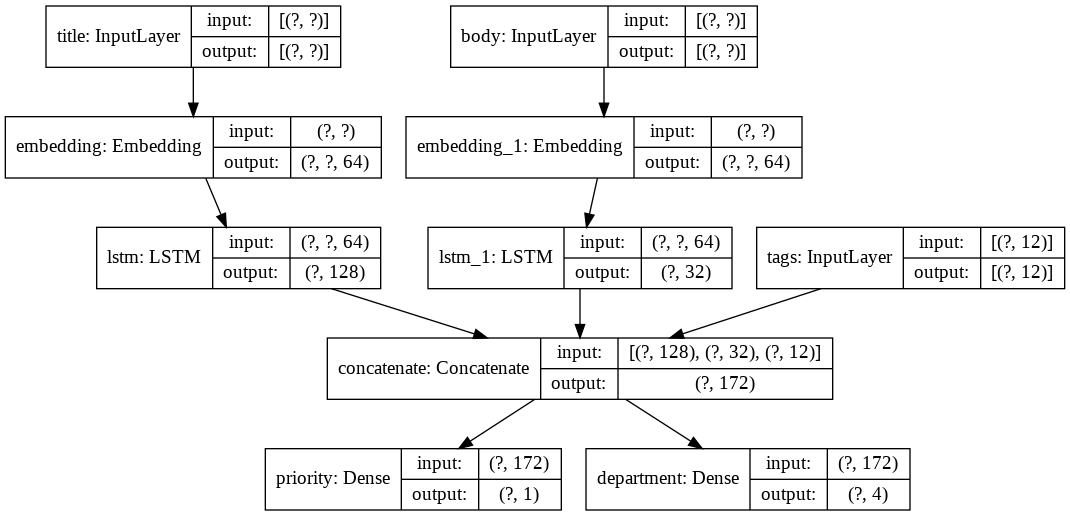

In [37]:
utils.plot_model(model, "intermediate/model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output. You can even assign different weights to each loss -- to modulate their contribution to the total training loss.

In [38]:
model.compile(
    optimizer=optimizers.RMSprop(1e-3),
    loss=[
        losses.BinaryCrossentropy(from_logits=True),
        losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

Since the output layers have different names, you could also specify the loss like this:

In [39]:
model.compile(
    optimizer=optimizers.RMSprop(1e-3),
    loss={
        "priority": losses.BinaryCrossentropy(from_logits=True),
        "department": losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

Train the model by passing lists of NumPy arrays of inputs and targets:

In [40]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

In [41]:
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 1s 20ms/step - loss: 1.2909 - priority_loss: 0.7052 - department_loss: 2.9282
Epoch 2/2
40/40 [==============================] - 1s 19ms/step - loss: 1.2869 - priority_loss: 0.6984 - department_loss: 2.9426


When calling fit with a Dataset object, it should yield either a tuple of lists like ([title_data, body_data, tags_data], [priority_targets, dept_targets]) or a tuple of dictionaries like ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets}).

# Shared layers
Another good use for the functional API are models that use shared layers. Shared layers are layer instances that are reused multiple times in the same model -- they learn features that correspond to multiple paths in the graph-of-layers.

Shared layers are often used to encode inputs from similar spaces (say, two different pieces of text that feature similar vocabulary). They enable sharing of information across these different inputs, and they make it possible to train such a model on less data. If a given word is seen in one of the inputs, that will benefit the processing of all inputs that pass through the shared layer.

To share a layer in the functional API, call the same layer instance multiple times. For instance, here's an Embedding layer shared across two different text inputs:

In [42]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

In [44]:
# Variable-length sequence of integers
text_input_a = layers.Input(shape=(None,), dtype="int32")

In [45]:
# Variable-length sequence of integers
text_input_b = layers.Input(shape=(None,), dtype="int32")

In [46]:
# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

# Extract and reuse nodes in the graph of layers
Because the graph of layers you are manipulating is a static data structure, it can be accessed and inspected. And this is how you are able to plot functional models as images.

This also means that you can access the activations of intermediate layers ("nodes" in the graph) and reuse them elsewhere -- which is very useful for something like feature extraction.

Let's look at an example. This is a VGG19 model with weights pretrained on ImageNet:

In [47]:
vgg19 = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 30s 0us/step


And these are the intermediate activations of the model, obtained by querying the graph data structure:

In [50]:
features_list = [layer.output for layer in vgg19.layers]

Use these features to create a new feature-extraction model that returns the values of the intermediate layer activations:

In [52]:
feat_extraction_model = models.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

This comes in handy for tasks like neural style transfer, among other things.

# Extend the API using custom layers

tf.keras includes a wide range of built-in layers, for example:
* Convolutional layers: Conv1D, Conv2D, Conv3D, Conv2DTranspose
* Pooling layers: MaxPooling1D, MaxPooling2D, MaxPooling3D, AveragePooling1D
* RNN layers: GRU, LSTM, ConvLSTM2D
* BatchNormalization, Dropout, Embedding, etc.

But if you don't find what you need, it's easy to extend the API by creating your own layers. All layers subclass the Layer class and implement:

* call method, that specifies the computation done by the layer.
* build method, that creates the weights of the layer (this is just a style convention since you can create weights in __init__, as well).

To learn more about creating layers from scratch, read custom layers and models guide.

The following is a basic implementation of tf.keras.layers.Dense:

In [53]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [55]:
inputs = layers.Input((4,))
outputs = CustomDense(10)(inputs)

model = models.Model(inputs, outputs)

For serialization support in your custom layer, define a get_config method that returns the constructor arguments of the layer instance:

In [61]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}

In [62]:
inputs = layers.Input((4,))
outputs = CustomDense(10)(inputs)

In [63]:
model = models.Model(inputs, outputs)
config = model.get_config()

In [65]:
new_model = models.Model.from_config(config, custom_objects={"CustomDense": CustomDense})